# Regression models for predicting solubility

Predicting solubility using sklearn's following regression models:
- Linear Regression
- Random Forest
- Gradient Boosting
- Support Vector Machine

First, models will be tested with unprocessed data, then normalized and standardized data, and finally together with tuned hyperparameters.
This is to compare how accurately models compare data based on the data given in, as well as how much optimum parameters improve performance compared to default paramters.

*(cleaner code is written in pipeline notebook)*

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

# for feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# for pre-processing data
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

# for performance evaluation
from sklearn.metrics import mean_squared_error, r2_score

# for building regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# for visualisating trees
# import graphviz
# from sklearn.tree import export_graphviz

## Split into training and test sets

In [6]:
# loading dataset as pandas dataframe
df = pd.read_csv('aqsoldb.csv')

In [7]:
# drop values which aren't descriptors
X = df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8]], axis=1)

In [8]:
y = df['Solubility']

In [9]:
# split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

## Feature Selection

In [19]:
# see what the top features based on mutual info regression
selector = SelectKBest(mutual_info_regression)
selector.fit(X, y)
X.columns[selector.get_support()]

Index(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumValenceElectrons',
       'NumAromaticRings', 'RingCount', 'LabuteASA', 'BalabanJ', 'BertzCT'],
      dtype='object')

In [20]:
selector.scores_

array([0.4199702 , 0.58277755, 0.39844165, 0.33422766, 0.10250405,
       0.06065992, 0.09740299, 0.08550744, 0.33164333, 0.16337582,
       0.01392007, 0.02471843, 0.15411457, 0.1182037 , 0.36603861,
       0.17390901, 0.2636557 ])

In [21]:
# looking at feature scores
scores = pd.DataFrame(data=[selector.feature_names_in_, selector.scores_])

In [22]:
scores

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
1,0.41997,0.582778,0.398442,0.334228,0.102504,0.06066,0.097403,0.085507,0.331643,0.163376,0.01392,0.024718,0.154115,0.118204,0.366039,0.173909,0.263656


In [23]:
scores_transposed = scores.transpose()
scores_transposed.rename(columns={0: 'Feature', 1: 'Score'}, inplace=True)
scores_transposed

,Feature,Score
0,MolWt,0.41997
1,MolLogP,0.582778
2,MolMR,0.398442
3,HeavyAtomCount,0.334228
4,NumHAcceptors,0.102504
5,NumHDonors,0.06066
6,NumHeteroatoms,0.097403
7,NumRotatableBonds,0.085507
8,NumValenceElectrons,0.331643
9,NumAromaticRings,0.163376


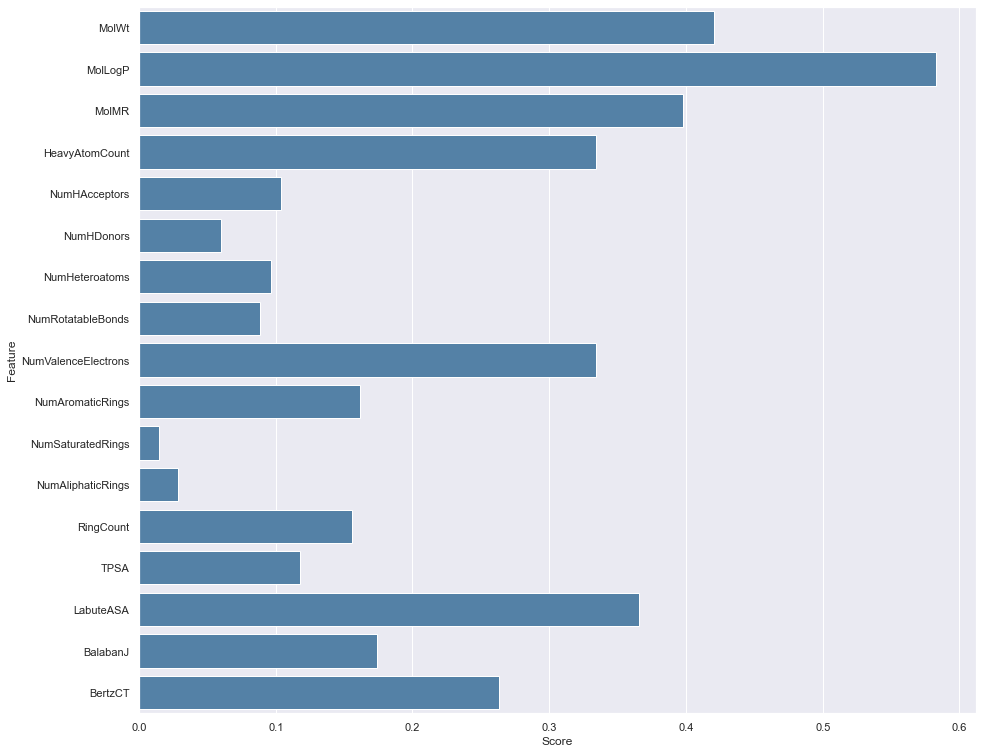

In [18]:
sns.barplot(data=scores_transposed, x='Score', y='Feature', color='steelblue')
# sns.set(rc = {'figure.figsize':(15,13)})
plt.savefig('solubility_features.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [27]:
# we can see there are 6 features that can be taken as most important and these will be used here
selector = SelectKBest(mutual_info_regression, k=6)
selector.fit(X_train, y_train)

SelectKBest(k=6, score_func=<function mutual_info_regression at 0x165f856c0>)

In [28]:
# features selected based on selector above
X_train_selected = selector.transform(X_train)

In [29]:
X_train_selected

array([[2.06329000e+02, 3.73810000e+00, 6.26100000e+01, 1.50000000e+01,
        8.40000000e+01, 9.29437553e+01],
       [9.01220000e+01, 1.52000000e-02, 2.35788000e+01, 6.00000000e+00,
        3.80000000e+01, 3.77418564e+01],
       [1.10200000e+02, 2.59000000e+00, 3.75920000e+01, 8.00000000e+00,
        4.60000000e+01, 5.22930712e+01],
       ...,
       [2.11129000e+02, 9.91200000e-01, 4.70150000e+01, 1.50000000e+01,
        7.80000000e+01, 8.27257748e+01],
       [2.38239000e+02, 1.81020000e+00, 6.27678000e+01, 1.70000000e+01,
        9.20000000e+01, 9.92278443e+01],
       [1.83638000e+02, 2.04180000e+00, 4.94695000e+01, 1.20000000e+01,
        6.40000000e+01, 7.67508515e+01]])

In [30]:
# transform test values into selected features only and then use to predict hcp values
X_test_selected = selector.transform(X_test)

## Using unprocessed data and untuned models

### Linear Regression

In [31]:
# build linear regresson model
regr = LinearRegression()

# fit model using training set
regr.fit(X_train_selected, y_train)

LinearRegression()

In [32]:
# intercept value
regr.intercept_

-1.6880073986636903

In [33]:
# gradient value
regr.coef_

array([-0.00694023, -0.50644808,  0.02989209, -0.21969472,  0.0519522 ,
       -0.01318015])

In [34]:
# predict solubility values using the test set
regr_y_predict = regr.predict(X_test_selected)

In [35]:
regr.score(X_train_selected, y_train)

0.47091582289356926

In [36]:
regr.score(X_test_selected, y_test)

0.4537340316208951

In [37]:
mean_squared_error(y_test, regr_y_predict)

# shows there is a high measure of error

3.1177644405787914

In [38]:
r2_score(y_test, regr_y_predict)

# shows poor goodness of fit

0.4537340316208951

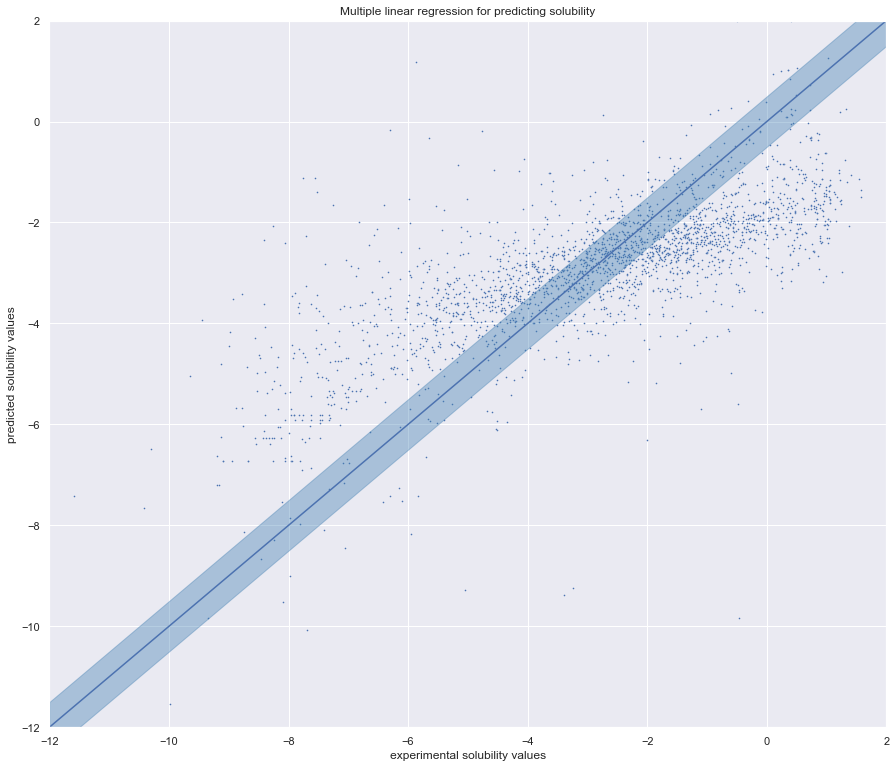

In [39]:
sns.scatterplot(x=y_test, y=regr_y_predict, s=3).set(title='Multiple linear regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

# plt.savefig('mlr_delaney.jpg', bbox_inches='tight')

### Random Forest

In [40]:
# build random forest regresson model
rf = RandomForestRegressor()

# fit model using training set
rf.fit(X_train_selected, y_train)

RandomForestRegressor()

In [41]:
rf.score(X_test_selected, y_test)

0.7174731402842741

In [42]:
rf.score(X_train_selected, y_train)

0.9582159900522512

In [43]:
# solubility values predicted using test labels
rf_y_predict = rf.predict(X_test_selected)

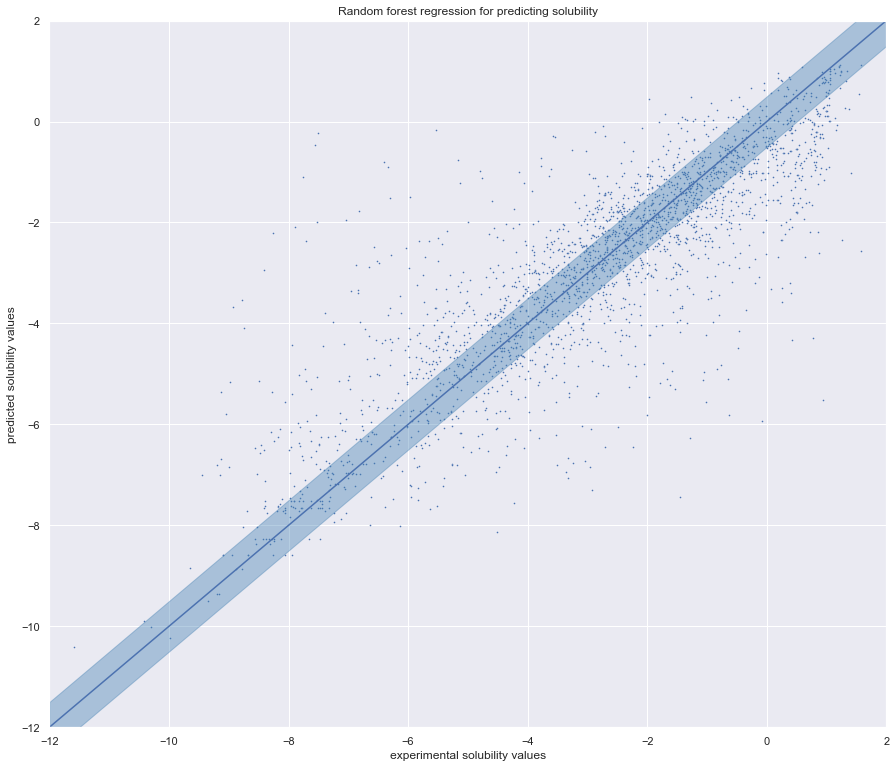

In [45]:
sns.scatterplot(x=y_test, y=rf_y_predict, s=3).set(title='Random forest regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

plt.savefig('rfr_solubility.jpg', bbox_inches='tight', dpi=300)

### Gradient Boosting

In [46]:
# build gradient boosting regressor model
gb = GradientBoostingRegressor()

# fit model using training set
gb.fit(X_train_selected, y_train)

GradientBoostingRegressor()

In [48]:
gb.score(X_test_selected, y_test)

0.6889062740041658

In [49]:
gb.score(X_train_selected, y_train)

0.746914705191981

In [47]:
# solubility values predicted using test labels
gb_y_predict = gb.predict(X_test_selected)

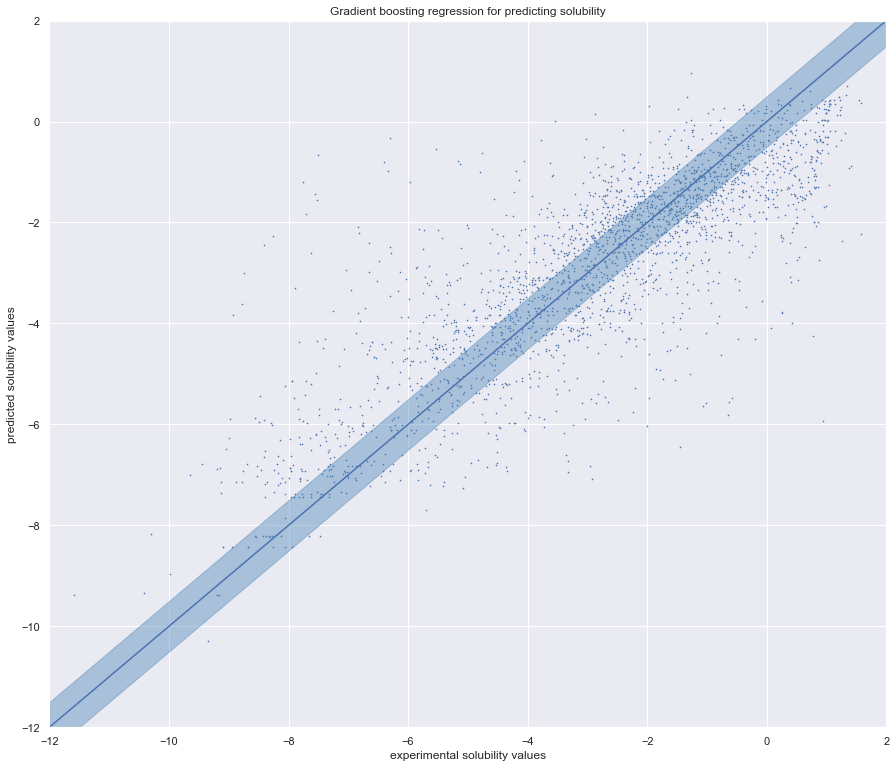

In [50]:
sns.scatterplot(x=y_test, y=gb_y_predict, s=3).set(title='Gradient boosting regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

### Support Vector Machine

In [51]:
# build svm regresson model
svm = SVR()

# fit model using training set
svm.fit(X_train_selected, y_train)

SVR()

In [52]:
svm.score(X_test_selected, y_test)

0.4991762117380817

In [53]:
svm.score(X_train_selected, y_train)

0.5174161220878886

In [54]:
# solubility values predicted using test labels
svm_y_predict = svm.predict(X_test_selected)

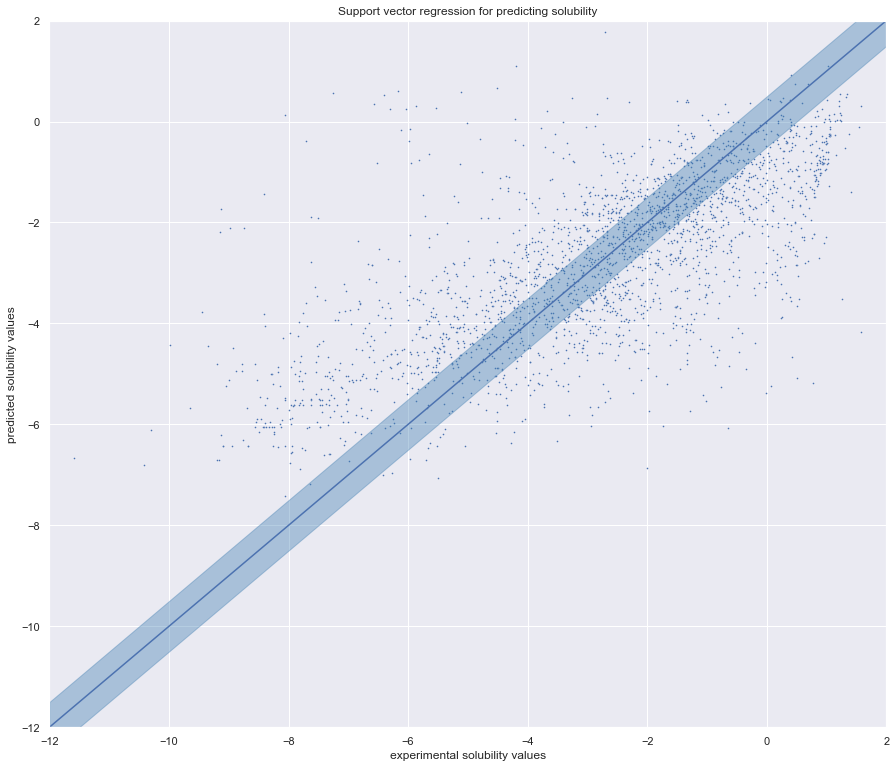

In [55]:
sns.scatterplot(x=y_test, y=svm_y_predict, s=3).set(title='Support vector regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

plt.savefig('svr_solubility.jpg', bbox_inches='tight', dpi=300)

## Using processed data

As can be seen in the first section, the features are of different magnitudes so to some models this will have a big impact and so to assist we can normalize and standardize the data.
Here, we apply Yeo-Johnson transformations to obtain normal distributions

In [56]:
# creating transformer which will carry out Yeo-Johnson transformation and also standardize the data
pt = PowerTransformer(method='yeo-johnson', standardize=True)

In [57]:
# apply power transformation to X training sets
X_train_trans = pt.fit_transform(X_train)
X_test_trans = pt.fit_transform(X_test)

In [58]:
# attach feature names to transformed sets so selected features can be identified
X_train_trans = pd.DataFrame(data=X_train_trans, columns=pt.feature_names_in_)
X_test_trans = pd.DataFrame(data=X_test_trans, columns=pt.feature_names_in_)

In [59]:
# reshape y so it can be transformed as well
reshaped_y_train = np.array(y_train).reshape(-1, 1)
reshaped_y_test = np.array(y_test).reshape(-1, 1)

In [60]:
# transform reshaped y values
y_train_trans = pt.fit_transform(reshaped_y_train)
y_test_trans = pt.fit_transform(reshaped_y_test)

In [61]:
# this is the lambda value used for the transformation - it can be used for the inverse transformation later on
pt.lambdas_

array([1.36608654])

In [62]:
y_train_trans

array([[-0.25739948],
       [ 2.09683793],
       [-0.41252937],
       ...,
       [ 0.2786169 ],
       [-0.08161468],
       [ 0.7510411 ]])

In [63]:
# formatting y so it can be correctly inputted into the following models
y_train_trans = np.ravel(y_train_trans)

In [64]:
# select top 6 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k=6)
selector.fit(X_train_trans, y_train)
X_train_trans.columns[selector.get_support()]

Index(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumValenceElectrons',
       'LabuteASA'],
      dtype='object')

In [65]:
selector.scores_

array([0.38850779, 0.57814628, 0.39848053, 0.31396596, 0.07919126,
       0.05625807, 0.0918134 , 0.08240633, 0.33336516, 0.16054009,
       0.01389302, 0.02697165, 0.15899148, 0.10705199, 0.37797362,
       0.16613743, 0.26757332])

In [66]:
# looking at feature scores
scores = pd.DataFrame(data=[selector.feature_names_in_, selector.scores_])

In [67]:
scores

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
1,0.388508,0.578146,0.398481,0.313966,0.079191,0.056258,0.091813,0.082406,0.333365,0.16054,0.013893,0.026972,0.158991,0.107052,0.377974,0.166137,0.267573


In [68]:
scores_transposed = scores.transpose()
scores_transposed.rename(columns={0: 'Feature', 1: 'Score'}, inplace=True)
scores_transposed

,Feature,Score
0,MolWt,0.388508
1,MolLogP,0.578146
2,MolMR,0.398481
3,HeavyAtomCount,0.313966
4,NumHAcceptors,0.079191
5,NumHDonors,0.056258
6,NumHeteroatoms,0.091813
7,NumRotatableBonds,0.082406
8,NumValenceElectrons,0.333365
9,NumAromaticRings,0.16054


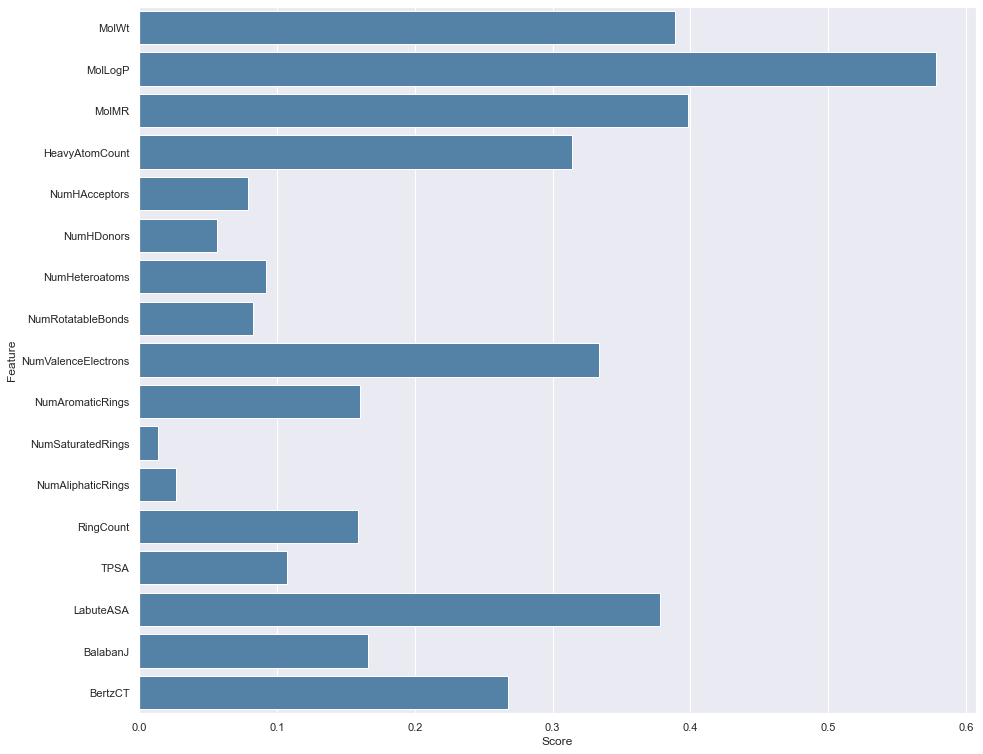

In [69]:
sns.barplot(data=scores_transposed, x='Score', y='Feature', color='steelblue')
sns.set(rc = {'figure.figsize':(15,13)})
# plt.savefig('solubility_features.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [70]:
# transforming training set to only use features selected above
X_train_trans_selected = selector.transform(X_train_trans)

In [71]:
X_train_trans_selected

array([[-0.18341876,  0.49163707,  0.09094833,  0.00328649,  0.03655929,
         0.00493815],
       [-1.70491948, -0.5704833 , -1.2566616 , -1.46020729, -1.25766194,
        -1.68372233],
       [-1.33455371,  0.16079794, -0.66965697, -1.02365628, -0.96121747,
        -1.06584294],
       ...,
       [-0.14134375, -0.29568671, -0.35248227,  0.00328649, -0.09152623,
        -0.20974325],
       [ 0.07949747, -0.06259019,  0.09504007,  0.21832993,  0.19586434,
         0.12503186],
       [-0.39673401,  0.00362591, -0.27684567, -0.37179369, -0.42609926,
        -0.34853056]])

In [72]:
# transforming test set to only use features selected above
X_test_trans_selected = selector.transform(X_test_trans)

### Linear Regression

In [73]:
# build linear regresson model
regr = LinearRegression()

# fit model using training set
regr.fit(X_train_trans_selected, y_train_trans)

LinearRegression()

In [74]:
# intercept value
regr.intercept_

7.923747037745864e-16

In [75]:
# gradient value
regr.coef_

array([-0.49034454, -0.61581005,  0.33755952, -1.21041527,  1.41518925,
       -0.30847273])

In [76]:
regr.score(X_train_trans_selected, y_train_trans)

0.552741546290445

In [77]:
regr.score(X_test_trans_selected, y_test_trans)

0.5116600678642987

In [78]:
# predict solubility values using the test set
regr_y_predict = regr.predict(X_test_trans_selected)

In [79]:
mean_squared_error(y_test_trans, regr_y_predict)

# shows there is a high measure of error

0.4883399321357014

In [80]:
# reshape y so it can be transformed 
reshaped_y_test = np.array(y_test_trans).reshape(-1, 1)
reshaped_y_pred = np.array(regr_y_predict).reshape(-1, 1)

# inverse transform y
reshaped_y_test = pt.inverse_transform(reshaped_y_test)
regr_y_predict = pt.inverse_transform(reshaped_y_pred)

# change y back to a 1D array
reshaped_y_test = np.ravel(reshaped_y_test)
regr_y_predict = np.ravel(regr_y_predict)

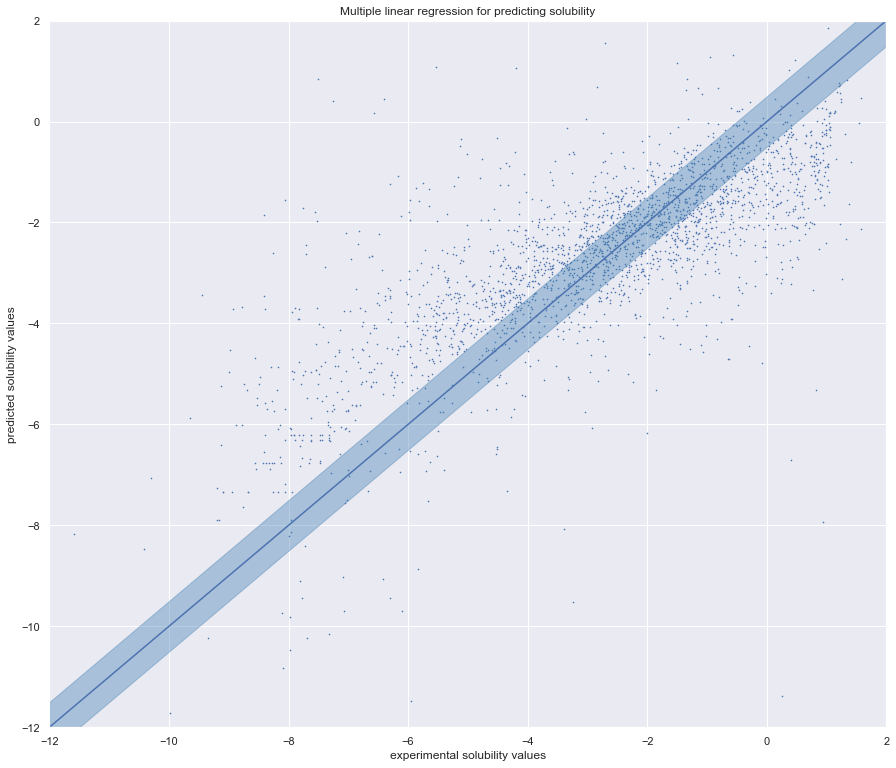

In [81]:
sns.scatterplot(x=reshaped_y_test, y=regr_y_predict, s=3).set(title='Multiple linear regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)
# plt.savefig('mlr_delaney.jpg', bbox_inches='tight')

### Random Forest

In [115]:
# build random forest regresson model
rf = RandomForestRegressor()

# fit model using training set
rf.fit(X_train_trans_selected, y_train_trans)

RandomForestRegressor()

In [116]:
rf.score(X_test_trans_selected, y_test_trans)

0.6900815866574239

In [117]:
rf.score(X_train_trans_selected, y_train_trans)

0.9578894759095283

In [118]:
# solubility values predicted using test labels
rf_y_predict = rf.predict(X_test_trans_selected)

In [119]:
mean_squared_error(y_test_trans, rf_y_predict, squared=False)

# shows there is a high measure of error

0.5567031644804763

In [87]:
# reshape y so it can be transformed 
reshaped_y_pred = np.array(rf_y_predict).reshape(-1, 1)

# inverse transform y
rf_y_predict = pt.inverse_transform(reshaped_y_pred)

# change y back to a 1D array
rf_y_predict = np.ravel(rf_y_predict)

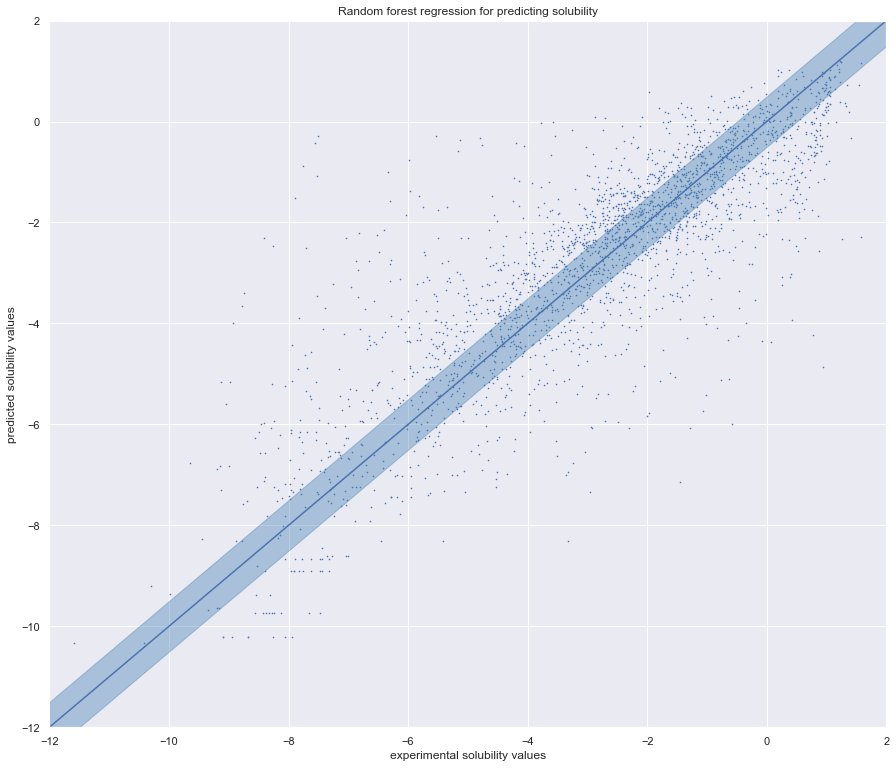

In [88]:
sns.scatterplot(x=reshaped_y_test, y=rf_y_predict, s=3).set(title='Random forest regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

plt.savefig('rfr_solubility_processed.jpg', bbox_inches='tight', dpi=300)

### Gradient Boosting

In [89]:
# build gradient boosting regressor model
gb = GradientBoostingRegressor()

# fit model using training set
gb.fit(X_train_trans_selected, y_train_trans)

GradientBoostingRegressor()

In [90]:
gb.score(X_test_trans_selected, y_test_trans)

0.671845962747113

In [91]:
gb.score(X_train_trans_selected, y_train_trans)

0.7391254645105336

In [92]:
# solubility values predicted using test labels
gb_y_predict = gb.predict(X_test_trans_selected)

In [93]:
# reshape y so it can be transformed 
reshaped_y_pred = np.array(gb_y_predict).reshape(-1, 1)

# inverse transform y
gb_y_predict = pt.inverse_transform(reshaped_y_pred)

# change y back to a 1D array
gb_y_predict = np.ravel(gb_y_predict)

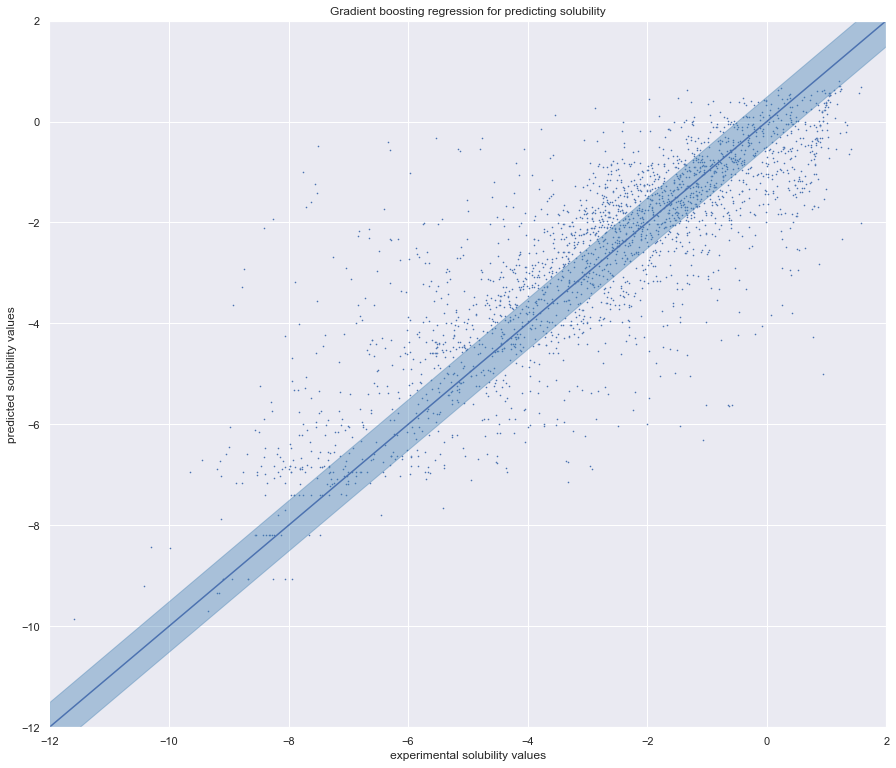

In [94]:
sns.scatterplot(x=reshaped_y_test, y=gb_y_predict, s=3).set(title='Gradient boosting regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

In [95]:
# check how many values fall within the allowed error boundary (of 0.5)
good_value_count = 0
for pred, exp in zip(gb_y_predict, reshaped_y_test):
    if exp - 0.5 <= pred <= exp + 0.5:
        good_value_count += 1

In [96]:
good_value_count

929

In [97]:
len(reshaped_y_test)

2496

In [98]:
print ('So', good_value_count / len(reshaped_y_test) * 100,'% of the test set are predicted within 0.5 of the experimental values.')

So 37.219551282051285 % of the test set are predicted within 0.5 of the experimental values.


### Support Vector Machine

In [99]:
# build svm regresson model
svm = SVR()

# fit model using training set
svm.fit(X_train_trans_selected, y_train_trans)

SVR()

In [100]:
svm.score(X_test_trans_selected, y_test_trans)

0.6940767925671864

In [101]:
svm.score(X_train_trans_selected, y_train_trans)

0.7314240948794524

In [105]:
# solubility values predicted using test labels
svm_y_predict = svm.predict(X_test_trans_selected)

In [106]:
# reshape y so it can be transformed 
reshaped_y_pred = np.array(svm_y_predict).reshape(-1, 1)

# inverse transform y
svm_y_predict = pt.inverse_transform(reshaped_y_pred)

# change y back to a 1D array
svm_y_predict = np.ravel(svm_y_predict)

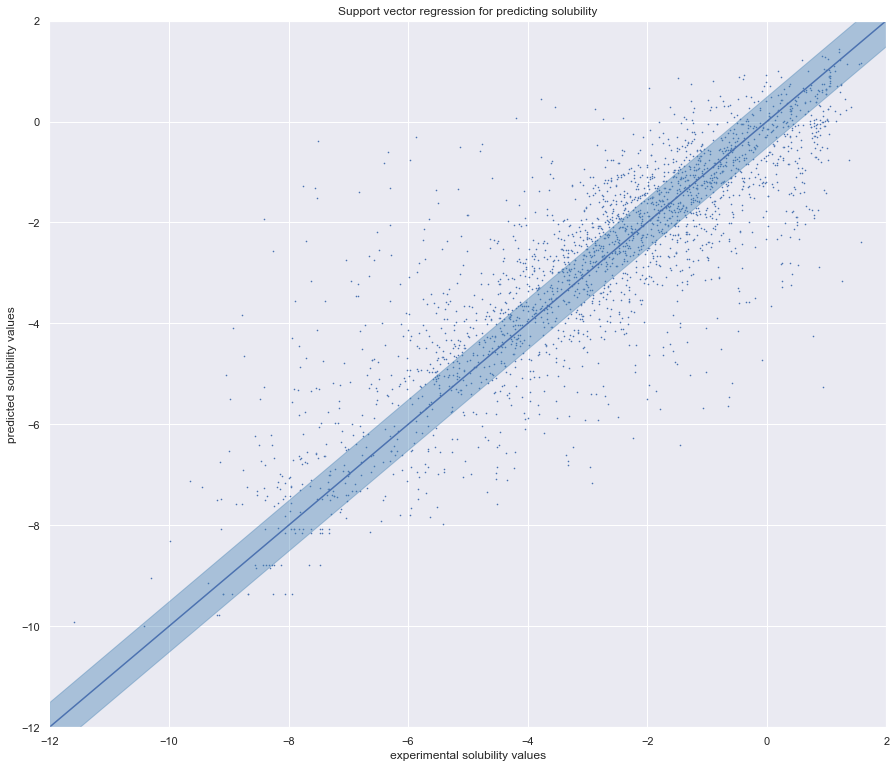

In [107]:
sns.scatterplot(x=reshaped_y_test, y=svm_y_predict, s=3).set(title='Support vector regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

plt.savefig('svr_solubility_processed.jpg', bbox_inches='tight', dpi=300)

## Using tuned parameters

In [120]:
rf = RandomForestRegressor()

In [80]:
# parameter grid containing hyperparameters to tune
param_grid = {'bootstrap': [True, False],
              'max_depth': [50, 100, 150, 200],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4],
              'n_estimators': [int(x) for x in np.linspace(200, 2000, 10)]}

In [81]:
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf_random = RandomizedSearchCV(estimator=rf, param_grid=param_grid, n_iter=100, cv=cvFold, verbose=2, random_state=7, n_jobs=-1)
results = rf_random.fit(x_train, y_train)

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


In [82]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 150,
 'bootstrap': True}

In [83]:
best_model = results.best_estimator_

In [84]:
best_model.score(X_test_trans_selected, y_test_trans)

0.7269850840991048

In [85]:
best_model.score(X_train_trans_selected, y_train_trans)

0.9171294450363431

Results = {'n_estimators': 1800,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 150,
 'bootstrap': True}

Using these results:

In [128]:
rf = RandomForestRegressor(n_estimators=1800, min_samples_split=4,min_samples_leaf=2, max_features='sqrt', max_depth=150, bootstrap=True)
rf.fit(X_train_trans_selected, y_train_trans)

RandomForestRegressor(max_depth=150, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=4, n_estimators=1800)

In [129]:
rf.score(X_test_trans_selected, y_test_trans)

0.7044875982957608

In [130]:
rf.score(X_train_trans_selected, y_train_trans)

0.9170002446363152

In [131]:
rftuned_y_predict = rf.predict(X_test_trans_selected)

In [132]:
# reshape y so it can be transformed 
reshaped_y_pred = np.array(rftuned_y_predict).reshape(-1, 1)

# inverse transform y
rftuned_y_predict = pt.inverse_transform(reshaped_y_pred)

# change y back to a 1D array
rftuned_y_predict = np.ravel(rftuned_y_predict)

In [133]:
# rmse for test set
mean_squared_error(y_test, rftuned_y_predict, squared=False)

1.2835500200655763

In [134]:
r2_score(y_test, rftuned_y_predict)

0.7113401100946889

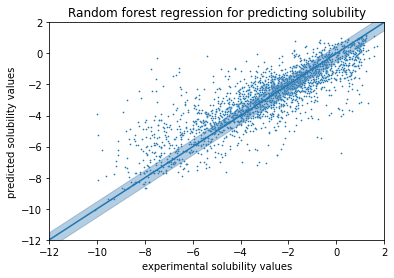

In [89]:
sns.scatterplot(x=reshaped_y_test, y=rftuned_y_predict, s=3).set(title='Random forest regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

plt.savefig('rf_tuned.jpg', bbox_inches='tight', dpi=300)

In [90]:
# check how many values fall within the allowed error boundary (of 0.5)
good_value_count = 0
for pred, exp in zip(rftuned_y_predict, reshaped_y_test):
    if exp - 0.5 <= pred <= exp + 0.5:
        good_value_count += 1

In [91]:
good_value_count

1112

In [92]:
len(reshaped_y_test)

2516

In [93]:
print ('So', good_value_count / len(reshaped_y_test) * 100,'% of the test set are predicted within 0.5 of the experimental values.')

So 44.19713831478537 % of the test set are predicted within 0.5 of the experimental values.


#### Visualisation

In [94]:
# visualisation of first tree in the forest
dot_data = export_graphviz(rf.estimators_[0], feature_names=list(x.columns), filled=True, impurity=True, rounded=True)
graph = graphviz.Source(dot_data, format='png')
graph.render('rf_solubility_visualisation')
graph

NameError: name 'export_graphviz' is not defined

### Support Vector Machine

In [95]:
# build svm regression model
svm = SVR()

In [96]:
# making parameter grid of hyperparameters to tune
grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 
        'tol': [1e-3, 1e-4, 1e-5, 1e-6], 
        'C': [1, 1.5, 2, 2.5, 3]}

In [97]:
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
gridSearch = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cvFold, scoring="neg_mean_squared_error")
results = gridSearch.fit(x_train, y_train)

In [98]:
gridSearch.best_params_

{'C': 3, 'kernel': 'rbf', 'tol': 1e-06}

In [99]:
best_model = results.best_estimator_

In [100]:
best_model.score(x_test, y_test)

0.7054653753602746

In [101]:
best_model.score(x_train, y_train)

0.7162309469839925

Best parameters are {'C': 3, 'kernel': 'rbf', 'tol': 1e-04}

In [326]:
svr = SVR(kernel='rbf', tol=1e-06, C=3)
svr.fit(x_train, y_train)

SVR(C=3, tol=1e-06)

In [327]:
svr.score(x_test, y_test)

0.7687306705611475

In [328]:
svr.score(x_train, y_train)

0.8038973739253744

In [103]:
svmtuned_y_predict = svr.predict(x_test)

In [104]:
# reshape y so it can be transformed 
reshaped_y_pred = np.array(svmtuned_y_predict).reshape(-1, 1)

# inverse transform y
svmtuned_y_predict = pt.inverse_transform(reshaped_y_pred)

# change y back to a 1D array
svmtuned_y_predict = np.ravel(svmtuned_y_predict)

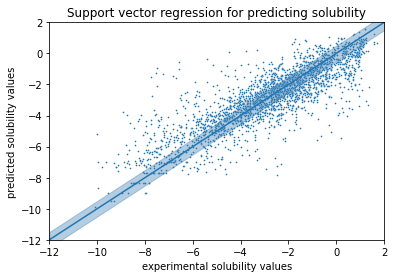

In [105]:
sns.scatterplot(x=reshaped_y_test, y=svmtuned_y_predict, s=3).set(title='Support vector regression for predicting solubility', xlabel='experimental solubility values', ylabel='predicted solubility values')

plt.xlim(-12, 2)
plt.ylim(-12, 2)

# plot x=y line showing where accurate predictions lie
sns.lineplot(x=[-12, 2], y=[-12, 2], alpha=1)

# shaded areas show values that lie within the accepted +- 0.5 error zone
exp_value = np.arange(-12, 3)
upper_bound = exp_value + 0.5
lower_bound = exp_value - 0.5
plt.fill_between(exp_value, upper_bound, lower_bound, color='steelblue', alpha=0.4)

plt.savefig('svr_tuned.jpg', bbox_inches='tight', dpi=300)

In [106]:
# check how many values fall within the allowed error boundary (of 0.5)
good_value_count = 0
for pred, exp in zip(svmtuned_y_predict, reshaped_y_test):
    if exp - 0.5 <= pred <= exp + 0.5:
        good_value_count += 1

In [107]:
good_value_count

1018

In [108]:
len(reshaped_y_test)

2516

In [109]:
print ('So', good_value_count / len(reshaped_y_test) * 100,'% of the test set are predicted within 0.5 of the experimental values.')

So 40.4610492845787 % of the test set are predicted within 0.5 of the experimental values.
